In [1]:
import numpy as np
import time,os
np.set_printoptions(linewidth=160)
from lib.ktn_io import *
from lib.gt_tools import *
from scipy.sparse import save_npz,load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [24]:

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

# Do we try a brute solve?
brute = True

# inverse temperature
beta = 8.0



# Load Data

In [25]:
Emax = None#-167.5

data_path = "KTN_data/LJ38/"

beta, B, K, D, N, u, s, kt, kcon, Emin = load_save_mat(path=data_path,beta=beta,Emax=Emax,Nmax=7000,generate=generate)

f = u-s/beta

"""
rm_reg = (np.arange(N)==D.diagonal().argmax())
B, D, N, retry = gt_seq(N=N,rm_reg=rm_reg,B=B,D=D.data,trmb=1)
K=B.dot(diags(D))
f = u[~rm_reg] - s[~rm_reg]/beta
"""


"""
Boolean vectors selecting A and/or B regions
"""
initial_states, final_states = np.zeros(N,bool), np.zeros(N,bool)
initial_states[np.loadtxt(os.path.join(data_path,'min_oct')).astype(int)-1] = True
final_states[np.loadtxt(os.path.join(data_path,'min_ico')).astype(int)-1] = True

basins = initial_states + final_states
inter_region = ~basins

rho_A, rho_B = np.zeros(N), np.zeros(N)

rho_B[initial_states] = np.exp(-(f[initial_states]-f[initial_states].min())*beta)
rho_B = rho_B[~final_states]
rho_B /= rho_B.sum()

rho_A[final_states] = np.exp(-(f[final_states]-f[final_states].min())*beta)
rho_A = rho_A[~initial_states]
rho_A /= rho_A.sum()

print("\n\t%d INITIAL STATES -> %d FINAL STATES\n" % (initial_states.sum(),final_states.sum()))

print("\n\tbeta:",beta," N:",N,"\n\n")

Generating....

	5 INITIAL STATES -> 395 FINAL STATES


	beta: 8.0  N: 5308 




# graph transformation

In [26]:
f_inter_region = inter_region.copy()

trmb = 50

rB, rD, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D.data,trmb=trmb)

r_initial_states = initial_states[~inter_region]
r_final_states = final_states[~inter_region]
r_basins = r_final_states + r_initial_states

print(r_basins.shape,r_basins.sum())

(400,) 400


# eigendecomposition of GT matrix 

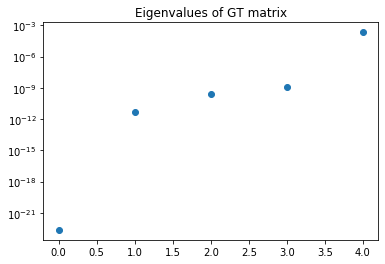


	  GAP  :  215819438532.69067

	  nu_0 : 2.2900427697363575e-23

	 k_qsd = C_AB.rD.qsd :  2.333743368223295e-23  % Error: -1.872553729856219 


	1.K.qsd: 2.3337449255115328e-23  % Error: -1.8726192094706384 




In [35]:
rK = diags(rD)-rB.dot(diags(rD))

K_AB = rK[initial_states,:][:,initial_states]

C_AB = np.ravel(rB[r_final_states,:][:,r_initial_states].sum(axis=0))

C_AB_rD = np.ravel(C_AB.dot(diags(rD[r_initial_states]).todense()))

l_AB, w_AB, v_AB = spla.eig(K_AB.todense(),left=True,right=True)


qsdo = np.abs(l_AB.real).argsort()

nu = l_AB.real[qsdo]


qsd = v_AB[:,qsdo[0]]
qsd /= qsd.sum()

rho = np.exp(-(f[initial_states]-f[initial_states].min())*beta)
rho /= rho.sum()

#aqsd = v_AB[:,qsdo[0]] / v_AB[:,qsdo[0]].sum()

plt.title("Eigenvalues of GT matrix")
plt.semilogy(np.arange(nu.size),nu,'o')
plt.show()

### Check for numerical consistency

We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}\,
[{\bf G}^\mathcal{I}_\mathcal{B}]^{-1}\,
\,{\bf D}^\mathcal{I}_\mathcal{B}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}$    =   "k_qsd"

I assume $\nu_0$ is the least reliable but I use it as reference

In [38]:

print("\n\t  nu_0 :",nu[0])

print("\n\t k_qsd = C_AB.rD.qsd : ", C_AB_rD.dot(qsd)," % Error:",(nu[0]/C_AB_rD.dot(qsd)-1.0)*100.0,"\n")

print("\n\t1.K.qsd:",K_AB.todense().dot(qsd).sum()," % Error:",(nu[0]/K_AB.todense().dot(qsd).sum()-1.0)*100.0,"\n\n")



	  nu_0 : 2.2900427697363575e-23

	 k_qsd = C_AB.rD.qsd :  2.333743368223295e-23  % Error: -1.872553729856219 


	1.K.qsd: 2.3337449255115328e-23  % Error: -1.8726192094706384 




# Transition rates and expected first passage times

In [46]:
C_AB_D = np.ravel(C_AB.dot(D[initial_states,:][:,initial_states].todense()))

kqsd = C_AB_rD.dot(qsd)

iK_AB = spla.inv(K_AB.todense())

trho = iK_AB.dot(rho).sum(axis=0)
tqsd = iK_AB.dot(qsd).sum(axis=0)

T_AB = iK_AB.sum(axis=0)


k_F = (rho/T_AB).sum()

#kqsd = k_F


print(
    "\n\t    ---- times ----   \n" \
    +
    "\n\t tau_AB : %3.6g \n" % (trho) \
    +
    "\n\t 1/nu_0 : %3.6g ( %3.6g%% )\n" % (1.0/nu[0],(trho*nu[0]-1.0)*100.0) \
    +
    "\n\t tau_QSD: %3.6g ( %3.6g%% )\n" % (tqsd,(trho/tqsd-1.0)*100.0) \
    +
    "\n\t1/k_QSD : %3.6g ( %3.6g%% )\n" % (1.0/C_AB_rD.dot(qsd),(trho*C_AB_rD.dot(qsd)-1.0)*100.0)
    +
    "\n\t    ---- rates ----   \n" \
    +
    "\n\t  k_qsd  : %3.6g\n" % kqsd \
    +
    "\n\t1/tau_AB: %3.6g ( %3.6g%% )\n" % (1.0/trho,np.abs(1.0/trho/kqsd-1.0)*100.0) \
    +
    "\n\t  k_SS  : %3.6g ( %3.6g%% )\n" % (C_AB_D.dot(rho),np.abs(C_AB_D.dot(rho)/kqsd-1.0)*100.0) \
    +
    "\n\t  k_NSS : %3.6g ( %3.6g%% )\n" % (C_AB_rD.dot(rho),np.abs(C_AB_rD.dot(rho)/kqsd-1.0)*100.0) \
    +
    "\n\t  nu_0 : %3.6g ( %3.6g%% )\n" % (nu[0],np.abs(nu[0]/kqsd-1.0)*100.0) \
    +
    "\n\t   k_F  : %3.6g ( %3.6g%% )\n" % (k_F,np.abs(k_F/kqsd-1.0)*100.0) \
)





	    ---- times ----   

	 tau_AB : 4.28497e+22 

	 1/nu_0 : 4.36673e+22 ( -1.87247% )

	 tau_QSD: 4.28497e+22 ( 7.77156e-13% )

	1/k_QSD : 4.28496e+22 ( 8.72022e-05% )

	    ---- rates ----   

	  k_qsd  : 2.33374e-23

	1/tau_AB: 2.33374e-23 ( 8.72021e-05% )

	  k_SS  : 2.33385e-23 ( 0.00451283% )

	  k_NSS : 2.22325e-23 ( 4.73478% )

	  nu_0 : 2.29004e-23 ( 1.87255% )

	   k_F  : 2.33374e-23 ( 8.72021e-05% )

